## SIMULATION OF SEIR INFECTIOUS DISEASE MODEL FOR COVID-19


In [16]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [17]:
%%time
#SEIR:易感   疑似   患病  康复  爬取33516条

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
## Some assumptions
Shanghai_population = 24894300

In [19]:
## Load data 
# df = pd.read_csv("../data/virus_china1.csv")
# 1 图3 2022 天津df = pd.read_csv("../data/天津8月.csv")
# 2 图4 2021 上海df = pd.read_csv("../data/上海1月.csv")
# 3 图5 2021 上海df = pd.read_csv("../data/上海12月.csv")
# df = pd.read_csv("../data/天津9月.csv")
df = pd.read_csv("../data/上海12月.csv")
"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'],format = '%Y%m%d')
# 1 df = df[df['date'] > datetime.datetime(2022, 7, 1)] 
# 2 df = df[df['date'] > datetime.datetime(2021, 1, 21)] 
# 3 df = df[df['date'] > datetime.datetime(2021, 11, 19)] 
# df = df[df['date'] > datetime.datetime(2021, 8, 1)]
df = df[df['date'] > datetime.datetime(2021, 11, 19)] 


### Load data and clean data

In [20]:
## Dataset preperation
df['R'] = df['cured'] + df['dead']
SIR_data = df[['date', 'Days','province', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})

In [21]:
# China total

# Use data before 2020-02-14 for train model
# 1Shanghai_total = SIR_data[SIR_data['date'] < datetime.datetime(2022, 7, 22)] 
# 2Shanghai_total = SIR_data[SIR_data['date'] < datetime.datetime(2021, 2, 12)] 
Shanghai_total = SIR_data[SIR_data['date'] < datetime.datetime(2021, 12, 10)] 
#Shanghai_total = SIR_data[SIR_data['date'] < datetime.datetime(2021, 9, 2)] 
Shanghai_total.tail(3)

,date,Days,province,I,E,R
18,2021-12-07,706,上海市,74,393,2822
19,2021-12-08,707,上海市,71,393,2827
20,2021-12-09,708,上海市,67,393,2832


### Estimate China Total

In [22]:
#rateIR：恢复率  rateAl：潜伏率 alpha：正则化参数 c: 尺度常数 b:偏置，天津：13866000；上海：24894300
Dynamic_SEIR1 = Train_Dynamic_SEIR(epoch = 10000, data = Shanghai_total, 
                 population = 24894300, rateAl 
                 = 1/8, rateIR=0.95, c = 5, b = -10, alpha = 0.08)

In [23]:
#求解到最优参数——梯度下降
estimation_df = Dynamic_SEIR1.train() 
est_beta = Dynamic_SEIR1.rateSI
est_alpha = Dynamic_SEIR1.alpha
est_b = Dynamic_SEIR1.b
est_c = Dynamic_SEIR1.c
population = Dynamic_SEIR1.numIndividuals

The loss in is 262.33834374999986
The MAPE in the whole period is 0.2251266454181974


In [24]:
# estimation_df.tail(2)

In [25]:
# Dynamic_SEIR1.plot_fitted_beta_R0(China_total)

In [26]:
# Dynamic_SEIR1.plot_fitted_result(China_total)

In [27]:
## use the last observation as the initial point in the new SEIR model

# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(Shanghai_total['I'])[-1]
# R=cured+dead
R0 = list(Shanghai_total['R'])[-1]
# E：潜伏
E0 = list(Shanghai_total['E'])[-1]
# S:health
S0 = population - I0 - E0 - R0
# print(list(Shanghai_total['I']))

In [28]:
#改进--动态SEIR   接触率随着时间的变化
seir_new = dynamic_SEIR(eons=10, Susceptible=S0, Exposed = E0, 
                    Infected=I0, Resistant=R0, rateIR=0.9, 
                    rateAl = 1/8, alpha = est_alpha, c = est_c, b = est_b)
result = seir_new.run(death_rate = 0.005) # assume death rate is 2%
# seir_new.plot_noSuscep('Dynamic SEIR for total', 'population', 'Date', starting_point = Shanghai_total['date'].max())


The MAPE is: 
0.37352037998993


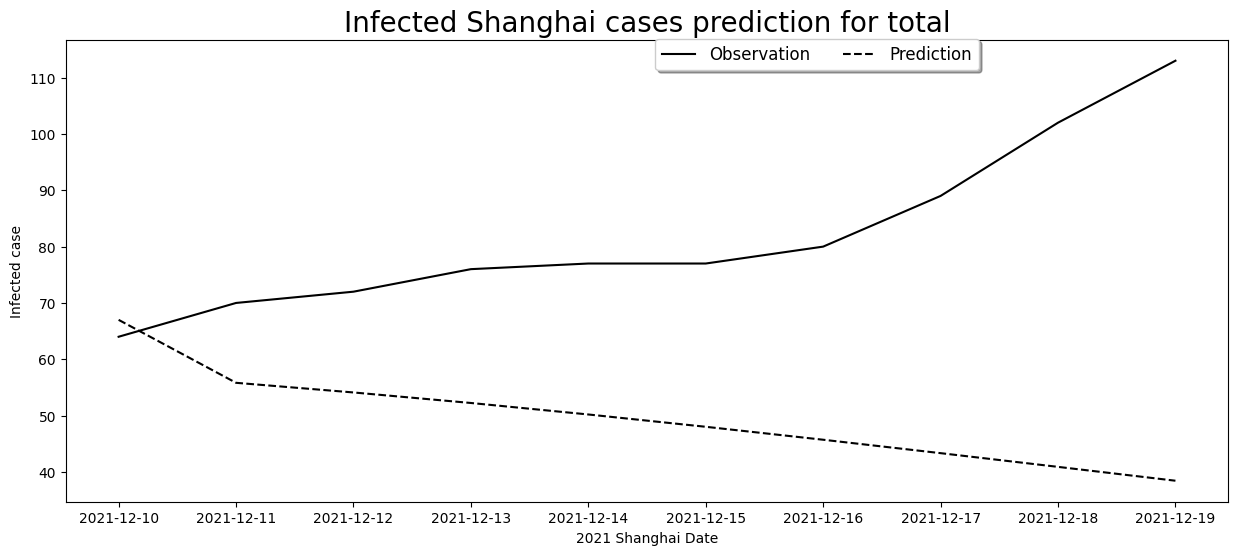

<Figure size 640x480 with 0 Axes>

In [29]:
"""
Calculate MAPE test score using SEIR model result
"""
# 1 test = SIR_data[SIR_data['date'] > datetime.datetime(2022, 7, 21)]
# 2 test = SIR_data[SIR_data['date'] > datetime.datetime(2021, 2, 11)]
test = SIR_data[SIR_data['date'] > datetime.datetime(2021, 12, 9)]
#test = SIR_data[SIR_data['date'] > datetime.datetime(2021, 9, 1)]
#  & SIR_data['date'] < datetime.datetime(2022, 4, 28)
plot_test_data_with_MAPE(test, result,'Infected Shanghai cases prediction for total')